In [1]:
from dinov2.data.loaders import make_dataset
import matplotlib.pyplot as plt
from dinov2.data import DataAugmentationDINO

import torch
import numpy as np
from tqdm import tqdm
from enum import Enum

from dinov2.data import (
    DataAugmentationDINO,
    MaskingGenerator,
    SamplerType,
    collate_data_and_cast,
    make_data_loader,
    make_dataset,
)

from dinov2.utils.utils import (
    CosineScheduler,
    exists,
    none_or_str,
)

from timeit import default_timer as timer

from dinov2.utils import utils

import torch.nn.functional as nnf

from functools import partial

from dinov2.models.vision_transformer import DinoVisionTransformer

from dinov2.layers import (
    MemEffAttention,
    Mlp,
    PatchEmbed,
    SwiGLUFFNFused,
)
from dinov2.layers import (
    NestedTensorBlock as Block,
)

from dinov2.data.augmentations import SegmentationAlgo

root = "/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/"
ds_path = f"LMDBDataset:split=TRAIN:root={root}:extra=*"

/hkfs/home/project/hk-project-p0021769/hgf_auh3910/repos/Masterproject-plankton-dinov2/dinov2/layers/attention.py:32: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/hkfs/home/project/hk-project-p0021769/hgf_auh3910/repos/Masterproject-plankton-dinov2/dinov2/layers/block.py:38: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
/hkfs/home/project/hk-project-p0021769/hgf_auh3910/repos/Masterproject-plankton-dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")


In [9]:
data_transform = DataAugmentationDINO(
    [0.32, 0.8],
    [0.05, 0.32],
    local_crops_number=8,
    global_crops_size=224,
    local_crops_size=96,
    use_kornia=False,
    use_native_res=False,
    do_seg_crops=None,
    patch_size=14
)

dataset = make_dataset(
    dataset_str=ds_path,
    # transform=data_transform_cpu,
    target_transform=lambda x: (),
    with_targets=True,
    cache_dataset=False,
)

INFO:dinov2:###################################
INFO:dinov2:Using data augmentation parameters:
INFO:dinov2:global_crops_scale: [0.32, 0.8]
INFO:dinov2:local_crops_scale: [0.05, 0.32]
INFO:dinov2:local_crops_number: 8
INFO:dinov2:global_crops_size: 224
INFO:dinov2:local_crops_size: 96
INFO:dinov2:###################################
/hkfs/home/project/hk-project-p0021769/hgf_auh3910/micromamba/envs/dinov2/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
INFO:dinov2:using dataset: "LMDBDataset:split=TRAIN:root=/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/:extra=*"
INFO:dinov2:# of dataset samples: 305,578


Dataset kwargs {'split': <_Split.TRAIN: 'train'>, 'root': '/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/', 'extra': '*'}
extra_full_path /home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/*-TRAIN_*
Datasets labels file list:  ['/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_labels']
Datasets imgs file list:  ['/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_imgs']
/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_imgs lmdb_env_imgs.stat() {'psize': 4096, 'depth': 4, 'branch_pages': 498, 'leaf_pages': 34082, 'overflow_pages': 8486, 'entries': 305578}


img.shape 0 torch.Size([3, 23, 19])
img.shape 1 torch.Size([3, 23, 19])
img.shape 2 torch.Size([3, 23, 19])


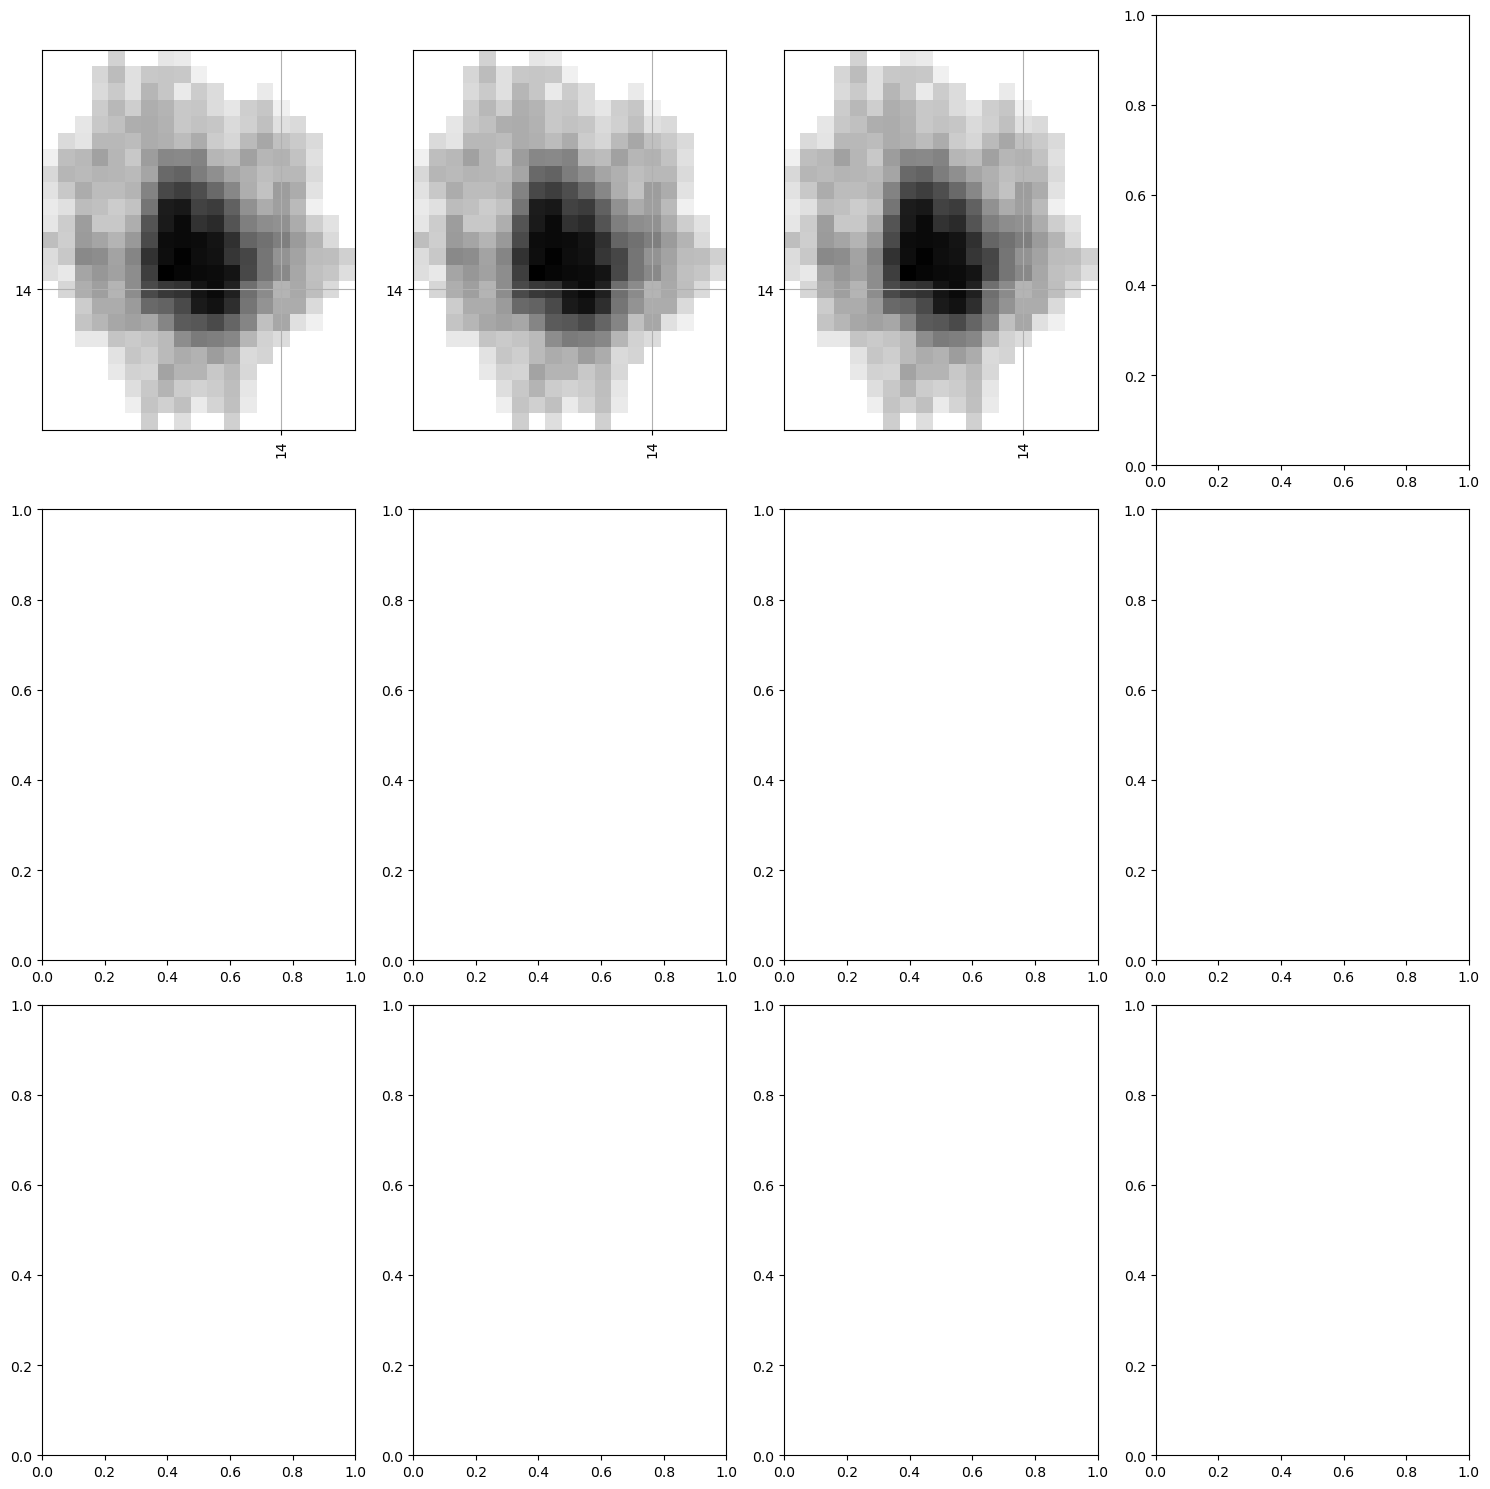

In [ ]:

imgs = dataset[2][0]
#print(imgs)
# dict_keys(['global_crops', 'local_crops', 'offsets'])

do_plot = True
"""
for k in imgs.keys():
    for img in imgs[k]:
        if torch.std(img) < 1e-3:
            print(torch.std(img))
            do_plot = True
            break

    # f2, a2 = plt.subplots(1, 1)
    # plt.hist(img.flatten(), bins=40)
"""
nb_x_plots, nb_y_plots = 3, 4
f, a = plt.subplots(nb_x_plots, nb_y_plots)
f.set_size_inches(15, 15)
f.tight_layout()
count = 0
for k in imgs.keys():
    print(k, len(imgs[k]))
    for img in imgs[k]:
        if len(img.shape) > 3:
            img = img[0]
        if len(img.shape) == 2:
            img = img[None, :, :].repeat((3, 1, 1))
        print("img.shape", count, img.shape)

        norm_img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
        a[count // 4, count % 4].imshow(norm_img.permute(1, 2, 0))
        a[count // 4, count % 4].set_title(k)
        xticks = np.arange(14, norm_img.shape[2], 14)
        yticks = np.arange(14, norm_img.shape[1], 14)
        a[count // 4, count % 4].set_xticks(xticks)
        a[count // 4, count % 4].set_yticks(yticks)
        a[count // 4, count % 4].xaxis.grid(True)
        a[count // 4, count % 4].yaxis.grid(True)
        a[count // 4, count % 4].set_xticklabels(xticks, rotation=90)
        count += 1
        # if count // 4 >= nb_x_plots or count % 4 >= nb_y_plots:
        #     break
    

In [ ]:
gpu_experiment = []

## CPU Code

In [ ]:
inputs_dtype = torch.half
img_size = 224
patch_size = 14
batch_size = 256
sampler_type = SamplerType.SHARDED_INFINITE

n_tokens = (img_size // patch_size) ** 2

mask_generator = MaskingGenerator(
    input_size=(
        img_size // patch_size,
        img_size // patch_size,
    ),
    max_num_patches=0.5 * img_size // patch_size * img_size // patch_size,
)

aug_kwargs = {
    "global_crops_scale": (0.32, 1.0),
    "local_crops_scale": (0.05, 0.32),
    "local_crops_number": 8,
    "global_crops_size": 224,
    "local_crops_size": 98,
    "patch_size": 14,
    "use_native_res": False,
    "do_seg_crops": None,
    "do_multi_channel": False,
}
data_transform_cpu = DataAugmentationDINO(use_kornia=True, **aug_kwargs)

collate_fn_cpu = partial(
    collate_data_and_cast,
    mask_ratio_tuple=(0.1, 0.5),
    mask_probability=0.5,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=inputs_dtype,
    do_free_shapes=None,
    use_ch_patch_embed=False,
    use_variable_channels=False,
)

dataset = make_dataset(
    dataset_str=ds_path,
    transform=data_transform_cpu,
    target_transform=lambda _: (),
    with_targets=False,
    cache_dataset=False,
)

dl_kwargs = {
    "dataset": dataset,
    "batch_size": batch_size,
    "num_workers": 16,
    "shuffle": True,
    "seed": 0,
    "sampler_type": sampler_type,
    "sampler_advance": 0,
    "drop_last": True,
}
data_loader = make_data_loader(collate_fn=collate_fn_cpu, **dl_kwargs)

"""
    for key in data.keys():
        if type(data[key]) == list:
            if len(data[key]) > 0: 
                print(f'{key}: {len(data[key])} x {data[key][0].shape}')
            else:
                print(f'{key}: empty')
        elif type(data[key]) == torch.Tensor:
            print(f'{key}: {data[key].shape}')
        else:
            print(f'{key}: {data[key]}')
    break
"""

batches = 100
start = timer()
for data in tqdm(data_loader):
    if batches <= 0:
        break
    batches -= 1
end = timer()

time = end - start
gpu_experiment.append({'batch_size': batch_size, 'device': 'cpu', 'time': time})
    


INFO:dinov2:###################################
INFO:dinov2:Using data augmentation parameters:
INFO:dinov2:global_crops_scale: (0.32, 1.0)
INFO:dinov2:local_crops_scale: (0.05, 0.32)
INFO:dinov2:local_crops_number: 8
INFO:dinov2:global_crops_size: 224
INFO:dinov2:local_crops_size: 98
INFO:dinov2:###################################
INFO:dinov2:using dataset: "LMDBDataset:split=TRAIN:root=/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/:extra=*"


Dataset kwargs {'split': <_Split.TRAIN: 'train'>, 'root': '/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/', 'extra': '*'}
extra_full_path /home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/*-TRAIN_*
Datasets labels file list:  ['/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_labels']
Datasets imgs file list:  ['/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_imgs']
/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_imgs lmdb_env_imgs.stat() {'psize': 4096, 'depth': 4, 'branch_pages': 498, 'leaf_pages': 34082, 'overflow_pages': 8486, 'entries': 305578}


INFO:dinov2:# of dataset samples: 305,578
INFO:dinov2:sampler: sharded infinite
INFO:dinov2:using PyTorch data loader
INFO:dinov2:infinite data loader
0it [00:00, ?it/s]

collated_global_crops: torch.Size([512, 3, 3584, 14])
collated_local_crops: torch.Size([2048, 3, 98, 98])
collated_masks: torch.Size([512, 256])
mask_indices_list: torch.Size([19508])
masks_weight: torch.Size([19508])
upperbound: 19610
n_masked_patches: torch.Size([1])
attn_mask_gc: None
attn_mask_lc: None
local_crop_len: None
local_patch_pos: None
local_crop_dims: None
num_ch_list: None


In [12]:
print(gpu_experiment)

[{'batch_size': 256, 'device': 'cpu', 'time': 354.3395479209721}, {'batch_size': 256, 'device': 'gpu', 'time': 38.9165871348232}]


## GPU Code

In [ ]:
def collate_fn_cpu(batch):
    collated = []
    for item in batch:
        image = item[0].unsqueeze(0)
        resized = nnf.interpolate(image, size=(128, 128), mode='bicubic')
        collated.append(resized)

    return torch.cat(collated, 0)

batch_size = 256

aug_kwargs = {
    "global_crops_scale": (0.32, 1.0),
    "local_crops_scale": (0.05, 0.32),
    "local_crops_number": 8,
    "global_crops_size": 224,
    "local_crops_size": 98,
    "patch_size": 14,
    "use_native_res": False,
    "do_seg_crops": None,
    "do_multi_channel": False,
}
data_transform = DataAugmentationDINO(use_kornia=True, **aug_kwargs)

dataset = make_dataset(
    dataset_str=ds_path,
    transform=None,
    target_transform=lambda _: (),
    with_targets=False,
    cache_dataset=False,
)

data_loader = make_data_loader(dataset=dataset, batch_size=batch_size, num_workers=16, collate_fn=collate_fn_cpu)


"""
    for key in data.keys():
        if len(data[key]) > 0: 
            print(f'{key}: {len(data[key])} x {data[key][0].shape}')
        else:
            print(f'{key}: empty')
    break
"""

batches = 100
start = timer()
for data in tqdm(data_loader):
    data = data.to(device=f"cuda:{torch.cuda.current_device()}")
    data = data_transform(data)
    if batches <= 0:
        break
    batches -= 1
end = timer()

time = end - start
#gpu_experiment.append({'batch_size': batch_size, 'device': 'gpu', 'time': time})


INFO:dinov2:###################################
INFO:dinov2:Using data augmentation parameters:
INFO:dinov2:global_crops_scale: (0.32, 1.0)
INFO:dinov2:local_crops_scale: (0.05, 0.32)
INFO:dinov2:local_crops_number: 8
INFO:dinov2:global_crops_size: 224
INFO:dinov2:local_crops_size: 98
INFO:dinov2:###################################
INFO:dinov2:using dataset: "LMDBDataset:split=TRAIN:root=/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/:extra=*"


Dataset kwargs {'split': <_Split.TRAIN: 'train'>, 'root': '/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/', 'extra': '*'}
extra_full_path /home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/*-TRAIN_*
Datasets labels file list:  ['/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_labels']
Datasets imgs file list:  ['/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_imgs']
/home/hk-project-p0021769/hgf_auh3910/own_data/ISIISNet/-TRAIN_imgs lmdb_env_imgs.stat() {'psize': 4096, 'depth': 4, 'branch_pages': 498, 'leaf_pages': 34082, 'overflow_pages': 8486, 'entries': 305578}


INFO:dinov2:# of dataset samples: 305,578
INFO:dinov2:sampler: infinite
INFO:dinov2:using PyTorch data loader
INFO:dinov2:infinite data loader
0it [00:01, ?it/s]

global_crops_vis: 2 x torch.Size([256, 3, 224, 224])
global_crops: 512 x torch.Size([3, 3584, 14])
local_crops: 2048 x torch.Size([3, 98, 98])
offsets: empty


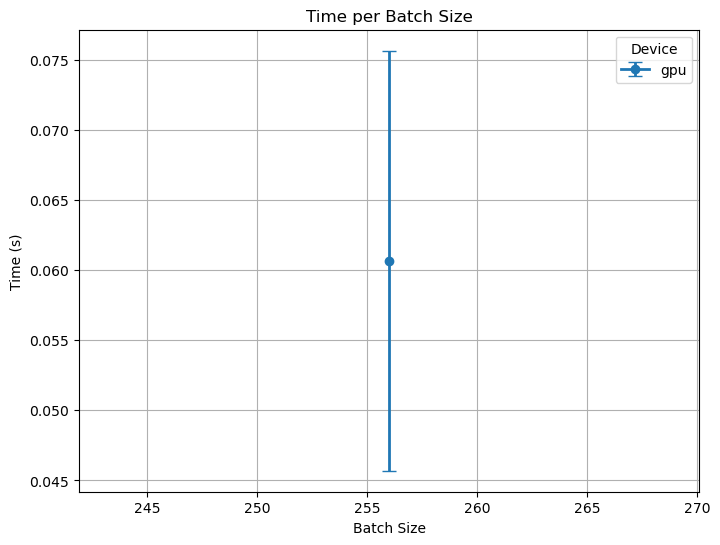

In [7]:
grouped_data = {}
for entry in gpu_experiment:
    device = entry['device']
    batch_size = entry['batch_size']
    # Initialize the device key if not present
    if device not in grouped_data:
        grouped_data[device] = {}
    # Initialize the batch_size key for the device if not present
    if batch_size not in grouped_data[device]:
        grouped_data[device][batch_size] = []
    # Append the time measurement
    grouped_data[device][batch_size].append(entry['time'])

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

for device, batch_dict in grouped_data.items():
    # Sort batch sizes for a cleaner plot
    batch_sizes = sorted(batch_dict.keys())
    mean_times = [np.mean(batch_dict[bs]) for bs in batch_sizes]
    std_times = [np.std(batch_dict[bs]) for bs in batch_sizes]
    
    ax.errorbar(batch_sizes, mean_times, yerr=std_times, marker='o', capsize=5,
                label=device, linestyle='-', linewidth=2)

ax.set_title("Time per Batch Size")
ax.set_xlabel("Batch Size")
ax.set_ylabel("Time (s)")
ax.legend(title="Device")
ax.grid(True)
plt.show()